# Proyecto 1: Análisis de Sentimiento

Clara Paola Aguilar Casillas

Daniela de la Torre Gallo

Samantha Sánchez Tinoco

### Carga de dataset

In [ ]:
import re
import random
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

#nltk.download("punkt")
#nltk.download("punkt_tab")
#nltk.download("stopwords")


from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importar y cargar los datos

In [2]:
IMDB_ROOT = Path("IMDB_data")  

In [3]:
def load_folder(folder_path):
    # folder_path: Path a carpeta 'pos' o 'neg'
    texts = []
    for p in folder_path.iterdir():
        if p.suffix == ".txt":
            # Leemos el contenido del archivo como texto
            texts.append(p.read_text(encoding="utf-8"))
    return texts

def load_imdb_local(root_path: Path):
    # Devuelve listas con formato (label_str, text_str) como torchtext
    train_pos = load_folder(root_path / "train" / "pos")
    train_neg = load_folder(root_path / "train" / "neg")
    test_pos  = load_folder(root_path / "test"  / "pos")
    test_neg  = load_folder(root_path / "test"  / "neg")
    # Construir listas con tuplas (label, text)
    train_list = [("pos", t) for t in train_pos] + [("neg", t) for t in train_neg]
    test_list  = [("pos", t) for t in test_pos]  + [("neg", t) for t in test_neg]
    return train_list, test_list


In [4]:
# Cargar datos
train_list, test_list = load_imdb_local(IMDB_ROOT)
print("Loaded examples -> train:", len(train_list), " test:", len(test_list))

Loaded examples -> train: 25000  test: 25000


In [5]:
# Separar X, y de las listas
def to_X_y(data_list):
    X = [text for (label, text) in data_list]
    y = [0 if label == "neg" else 1 for (label, text) in data_list]
    return X, y

X_full, y_full = to_X_y(train_list)
X_test, y_test = to_X_y(test_list)

# Train test split
X_train, X_dev, y_train, y_dev = train_test_split(
    X_full, y_full, test_size=0.1, random_state=42, stratify=y_full
)

print("Dataset sizes -> train:", len(X_train), " dev:", len(X_dev), " test:", len(X_test))


Dataset sizes -> train: 22500  dev: 2500  test: 25000


## Pre-procesamiento de datos

In [12]:
# Preparar stopwords de NLTK en inglés
STOPWORDS = set(stopwords.words("english"))

def preprocess_text(text, remove_stopwords=True):
    # Minúsculas
    text = text.lower()
    # Quitar los caracteres que no son letras ni espacios
    text = re.sub(r"[^a-z\s]", " ", text)
    # Colapsar espacios múltiples y quitar espacios al inicio/final
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Quitar stopwords si necesario
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens

## Funciones para imprimir resultados y visualizar matrices de confusión

In [13]:
# Matriz de confusión
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["neg","pos"], yticklabels=["neg","pos"])
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.show()


In [14]:
# Reporte del modelo -- métricas y confusión
def report_model(name, y_true, y_pred, plot_cm=True):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}  Precision: {precision:.4f}  Recall: {recall:.4f}  F1: {f1:.4f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=["neg","pos"]))
    if plot_cm:
        plot_confusion(y_true, y_pred, title=f"Confusion Matrix - {name}")

## Entrenamiento de modelos 


### Regresión logística

In [15]:
# Definir parámetros
tfidf_vec_lr = TfidfVectorizer(
    tokenizer=lambda text: preprocess_text(text, remove_stopwords=True),  
    lowercase=False,    # ya los quitamos en preprocesamiento
    ngram_range=(1,3),
    max_features=30000,
    min_df=3
)
clf_lr = LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1, random_state=42)

In [18]:
# Pipeline y entrenamiento
pipe_lr = Pipeline([("tfidf", tfidf_vec_lr), ("clf", clf_lr)])
pipe_lr.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,None
,tokenizer,<function <la...0020CEC3AFBE0>



=== LogisticRegression (dev) ===
Accuracy: 0.8820  Precision: 0.8687  Recall: 0.9000  F1: 0.8841
Classification report:
              precision    recall  f1-score   support

         neg       0.90      0.86      0.88      1250
         pos       0.87      0.90      0.88      1250

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



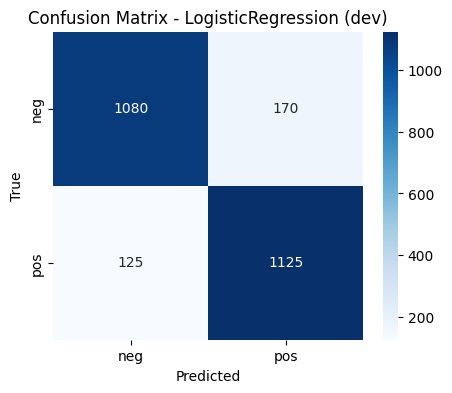

In [19]:
# Evaluar en datos de validación
pred_dev_lr = pipe_lr.predict(X_dev)
report_model("LogisticRegression (dev)", y_dev, pred_dev_lr)


=== LogisticRegression (test) ===
Accuracy: 0.8869  Precision: 0.8857  Recall: 0.8886  F1: 0.8871
Classification report:
              precision    recall  f1-score   support

         neg       0.89      0.89      0.89     12500
         pos       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



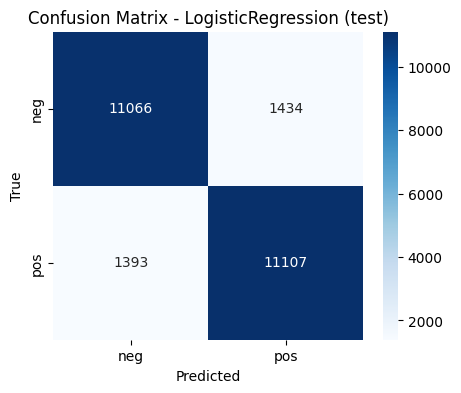

In [20]:
# Evaluar en datos de test
pred_test_lr = pipe_lr.predict(X_test)
report_model("LogisticRegression (test)", y_test, pred_test_lr)

### Multinomial Naive Bayes 

In [21]:
# Definir parámetros
count_vec_nb = CountVectorizer(
    tokenizer=lambda text: preprocess_text(text, remove_stopwords=True),
    lowercase=False,
    ngram_range=(1,3),
    max_features=30000,
    min_df=3
)
clf_nb = MultinomialNB()

In [22]:
# Pipeline y entrenamiento
pipe_nb = Pipeline([("bow", count_vec_nb), ("clf", clf_nb)])
pipe_nb.fit(X_train, y_train)

c:\Users\samys\Documents\Software\Anaconda\envs\MineriaTextos\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('bow', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,None
,tokenizer,<function <la...0020CF3E78670>



=== MultinomialNB (dev) ===
Accuracy: 0.8664  Precision: 0.8664  Recall: 0.8664  F1: 0.8664
Classification report:
              precision    recall  f1-score   support

         neg       0.87      0.87      0.87      1250
         pos       0.87      0.87      0.87      1250

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



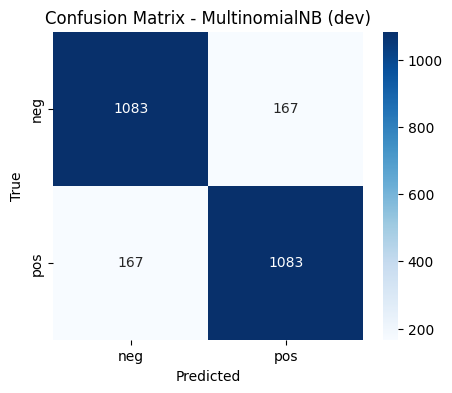

In [23]:
# Evaluar en datos de validación
pred_dev_nb = pipe_nb.predict(X_dev)
report_model("MultinomialNB (dev)", y_dev, pred_dev_nb)


=== MultinomialNB (test) ===
Accuracy: 0.8497  Precision: 0.8682  Recall: 0.8246  F1: 0.8459
Classification report:
              precision    recall  f1-score   support

         neg       0.83      0.87      0.85     12500
         pos       0.87      0.82      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



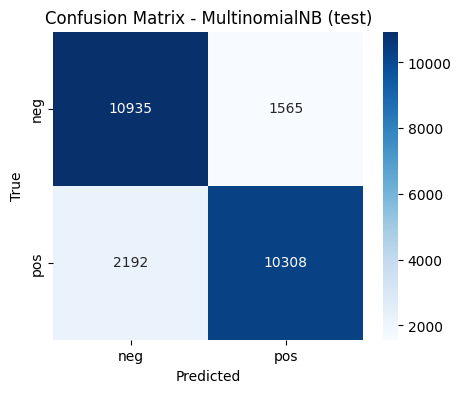

In [24]:
# Evaluar en datos de test
pred_test_nb = pipe_nb.predict(X_test)
report_model("MultinomialNB (test)", y_test, pred_test_nb)

### Linear Support Vector Machine

In [25]:
# Definir parámetros
tfidf_vec_svm = TfidfVectorizer(
    tokenizer=lambda text: preprocess_text(text, remove_stopwords=True),
    lowercase=False,
    ngram_range=(1,3),
    max_features=30000,
    min_df=3
)
clf_svm = LinearSVC(max_iter=20000, random_state=42)

In [26]:
# Pipeline y entrenamiento
pipe_svm = Pipeline([("tfidf", tfidf_vec_svm), ("clf", clf_svm)])
pipe_svm.fit(X_train, y_train)


c:\Users\samys\Documents\Software\Anaconda\envs\MineriaTextos\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,None
,tokenizer,<function <la...0020C93526EF0>



=== LinearSVC (dev) ===
Accuracy: 0.8820  Precision: 0.8763  Recall: 0.8896  F1: 0.8829
Classification report:
              precision    recall  f1-score   support

         neg       0.89      0.87      0.88      1250
         pos       0.88      0.89      0.88      1250

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



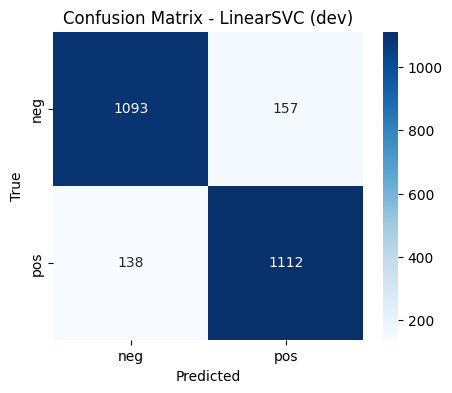

In [27]:
# Evaluar en el set de validación
pred_dev_svm = pipe_svm.predict(X_dev)
report_model("LinearSVC (dev)", y_dev, pred_dev_svm)


=== LinearSVC (test) ===
Accuracy: 0.8751  Precision: 0.8817  Recall: 0.8666  F1: 0.8740
Classification report:
              precision    recall  f1-score   support

         neg       0.87      0.88      0.88     12500
         pos       0.88      0.87      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



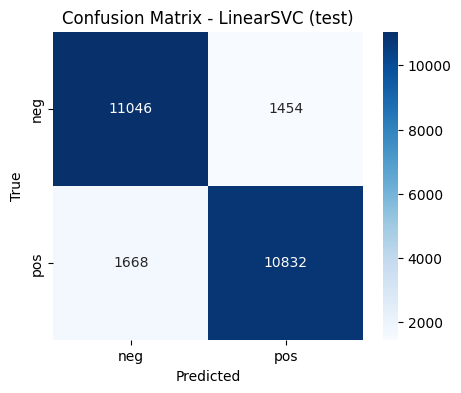

In [28]:
# Evaluar en los datos de test
pred_test_svm = pipe_svm.predict(X_test)
report_model("LinearSVC (test)", y_test, pred_test_svm)

## Mostrar algunos errores

In [29]:
def show_errors(model_pipe, X, y_true, n=5):
    y_pred = model_pipe.predict(X)
    errors_idx = [i for i,(yt,yp) in enumerate(zip(y_true, y_pred)) if yt != yp]
    print(f"\nMostrando {n} errores (de {len(errors_idx)}) del modelo {model_pipe.steps[-1][0]}:")
    for idx in errors_idx[:n]:
        print("----")
        print("Label verdadero:", y_true[idx], "Pred:", y_pred[idx])
        print("Pedazo de texto:", X[idx][:400].replace("\n"," ") + "...")
    if not errors_idx:
        print("Sin errores.")

# Cambiar la pipile para mostrar otro modelo
show_errors(pipe_lr, X_dev, y_dev, n=5)


Mostrando 5 errores (de 295) del modelo clf:
----
Label verdadero: 0 Pred: 1
Pedazo de texto: I saw this movie two weeks ago at the "festival des nouvelles images du Japon" in Paris. Though i wasn't expecting much from it, i have to say i've been disappointed just like many people in the audience... if i wanted to sum up how i felt, i'd say i've been comparing it to princess mononoke and nausicaa from the beginning to the end. Of course it's silly. But i couldn't help it. The stories are q...
----
Label verdadero: 1 Pred: 0
Pedazo de texto: Ok, after reading a couple of reviews on Atlantis: The Lost Empire, I just want to clear up some misunderstanding as to it being a direct rip off from Nadia: Secret of the Blue Water. The only part that was a ripoff from Nadia is that the pendant from Nadia and the pendant from Atlantis bear so much resemblence in terms of how it's used, origins and how it's created from the source of life that th...
----
Label verdadero: 1 Pred: 0
Pedazo de texto: